# Training a reflectorch model

First, we import the necessary methods from the `reflectorch` package, as well as othar basic Python packages:

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from ipywidgets import interact

from reflectorch import *
from reflectorch.extensions.jupyter import JPlotLoss

torch.manual_seed(0); # set seed for reproducibility

## The training loop

For training a model we use the `Trainer` class, which contains all the components necessary training process such as the data generator, the neural network and the optimizer.

 We can initialize the trainer according to the specifications defined in a YAML configuration file using the `get_trainer_by_name` method which takes as input the name of the configuration file. If the package was installed in editable model, the configuration files are read from the `configs` directory located inside the repository, otherwise the path to the directory containing the configuration file should also be specified using the `config_dir` argument. The `load_weights` argument should be set to `False` since we want the neural network weights to be randomly initialized for a fresh training.

In [52]:
config_name = 'c_L5_d200_s150_r60_ws5_q03_nq256'
trainer = get_trainer_by_name(config_name, load_weights=False)

Model c_L5_d200_s150_r60_ws5_q03_nq256 loaded. Number of parameters: 13.40 M


The trainer contains several important attributes we can inspect:

  1. The Pytorch optimizer. We can observe that the optimizer specified in the configuration is `AdamW`:

In [53]:
trainer.optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.999]
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)

:::{note}
The learning rate can be easily changed using `trainer.set_lr(new_lr)`
:::

  2. The batch size

In [54]:
trainer.batch_size, trainer.lr(), trainer.clip_grad_norm_max, trainer.train_with_q_input

(4096, 0.0001, True, False)

  3. The Pytorch neural network module. We can see that the network is an instance of the class `NetworkWithPriorsConvEmb`. This architecture consists of a multilayer perceptron (MLP) with residual connections, batch normalization layers and GELU activations (`trainer.model.mlp`). A 1D CNN embedding network (`trainer.model.embedding_net`) produces a latent embedding of the input batch of reflectivity curves which is concatenated with the prior bounds for the thin film parameters.

In [55]:
trainer.model

NetworkWithPriorsConvEmb(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(ap

We can add functionality to the training process using callback objects, such as:

  1. `JPlotLoss` - allows the interactive visualization of the loss curve when training inside a Jupyter Notebook, the `frequency` argument setting the refresh rate of the interactive widget

  2. `StepLR` - implements a learning rate scheduler which decreases the learning rate in steps (after a number of iterations defined by `step_size` the learning rate is multiplied by the factor `gamma`). Other types of learning rate schedulers can alternatively be used, such as `CyclicLR`, `LogCyclicLR`, `OneCycleLR` or `ReduceLROnPlateau`.

  3. `SaveBestModel` - it enables the periodic saving of the weights of the neural network during training. After a number of iterations defined by the `freq` argument, the weights of the neural network are saved at the specified `path` if the current average loss (computed over the last `average` iterations) is lower than the loss for the previous save. The history of the losses and learning rate values is also saved.

When the package is installed in editable mode, the default save path is relative to the repository directory (defined by the global variable `SAVED_MODELS_DIR`). 

In [56]:
save_model_name = 'model_' + config_name + '.pt'
save_path = str(SAVED_MODELS_DIR / save_model_name)

We group the callback objects together in a touple:

In [57]:
callbacks = (
    JPlotLoss(frequency=10, log=True), 
    StepLR(step_size=1800, gamma=0.9, last_epoch=-1), 
    SaveBestModel(path=save_path, freq=100, average=10),
)

:::{note}
The callbacks can also be initialized directly from the configuration file:
`callbacks = get_callbacks_by_name(config_name)`
:::

The training process is initiated by invoking the `train` method of the trainer. This method accepts as arguments the previously defined tuple of callbacks, as well as the number of iterations (batches). Notably, a new batch of data is generated at each iteration, the training taking place in a "one-epoch regime".

In [58]:
trainer.lr()

0.0001

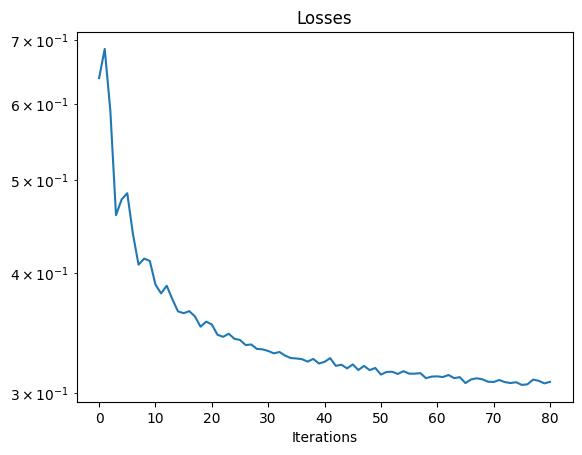

In [59]:
num_batches = 50000
trainer.train(num_batches=num_batches, callbacks=callbacks)

After training, the history of the losses and learning rates can be accessed via `trainer.losses` and `trainer.lrs`. We can also find them together with the model state_dict in the saved dictionary:

In [40]:
torch.load(save_path).keys()

dict_keys(['model', 'lrs', 'losses', 'prev_save', 'batch_num', 'best_loss'])

:::{tip}
:class: dropdown

The saved weights can be loaded into a compatible neural network (`net`) as:

```python
saved_dict = torch.load(save_path)
model_state_dict = saved_dict['model']
net.load_state_dict(model_state_dict)
```

:::

In [13]:
batch_size = 64
trainer.loader.calc_denoised_curves = True
simulated_data = trainer.loader.get_batch(batch_size=batch_size)

simulated_data.keys()

dict_keys(['params', 'scaled_params', 'q_values', 'curves', 'scaled_noisy_curves'])

In [14]:
q = simulated_data['q_values']
scaled_noisy_curves = simulated_data['scaled_noisy_curves']
unscaled_noisy_curves = trainer.loader.curves_scaler.restore(scaled_noisy_curves)
denoised_curves = simulated_data['curves']
scaled_denoised_curves = trainer.loader.curves_scaler.scale(denoised_curves)

@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=24)
    ax.set_ylabel('R$_{scaled}$ (q)', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=15)
        
    ax.scatter(to_np(q[i]), to_np(scaled_noisy_curves[i]), c='blue', s=2.0)
    ax.plot(to_np(q[i]), to_np(scaled_denoised_curves[i]), c='green', lw=1)

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

In [15]:
n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 2,  Number of film parameters: 11


In [16]:
scaled_bounds = simulated_data['scaled_params'][..., n_params:]

print(scaled_bounds.shape)

scaled_input = torch.cat([scaled_noisy_curves, scaled_bounds], dim=-1).float()

print(scaled_input.shape)

with torch.no_grad():
    trainer.model.eval()
    
    scaled_predicted_params = trainer.model(scaled_input)
    
print(scaled_predicted_params.shape)

restored_predictions = trainer.loader.prior_sampler.restore_params(torch.cat([scaled_predicted_params, scaled_bounds], dim=-1))
print(restored_predictions)
restored_predictions

predicted_curves = restored_predictions.reflectivity(q)


torch.Size([64, 22])
torch.Size([64, 278])
torch.Size([64, 11])
ParametricParams(batch_size=64, max_layer_num=2, device=cuda:0)


In [17]:
trainer.loader.prior_sampler.clamp_params(restored_predictions, inplace=True)

ParametricParams(batch_size=64, max_layer_num=2, device=cuda:0)

In [22]:
from reflectorch import get_param_labels, get_density_profiles

@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].set_yscale('log')
    ax[0].set_ylim(0.5e-10, 5)

    ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax[0].set_ylabel('R(q)', fontsize=20)

    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
        
    ax[0].plot(q[i].cpu().numpy(), predicted_curves[i].cpu().numpy() + 1e-10, c='r', lw=1, label='prediction')
    ax[0].scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, c='b', s=2, label='input sim. curve')

    ax[0].legend(loc='upper right', fontsize=14)

    z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
    _, sld_profile_gt, _ = get_density_profiles(
         simulated_data['params'].thicknesses, 
         simulated_data['params'].roughnesses,
         simulated_data['params'].slds,
         z_axis)
    
    _, sld_profile_pred, _ = get_density_profiles(
         restored_predictions.thicknesses, 
         restored_predictions.roughnesses,
         restored_predictions.slds,
         z_axis)
    
#     _, img_sld_profile_gt, _ = get_density_profiles(
#          simulated_data['params'].thicknesses, 
#          simulated_data['params'].roughnesses,
#          simulated_data['params'].slds.imag,
#          z_axis)
    
#     _, img_sld_profile_pred, _ = get_density_profiles(
#          restored_predictions.thicknesses, 
#          restored_predictions.roughnesses,
#          restored_predictions.slds.imag,
#          z_axis)
    
    
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_pred[i].cpu().numpy(), c='r', label='prediction')
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_gt[i].cpu().numpy(), c='b', label='ground truth')
#     ax[1].plot(z_axis.cpu().numpy(), img_sld_profile_pred[i].cpu().numpy(), c='pink', label='prediction')
#     ax[1].plot(z_axis.cpu().numpy(), img_sld_profile_gt[i].cpu().numpy(), c='cyan', label='ground truth')

    ax[1].set_xlabel('z [$Å$]', fontsize=20)
    ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
    
    plt.tight_layout()

    for l, t, p, min_b, max_b in zip(
          get_param_labels(n_layers),
          simulated_data['params'].parameters[i], 
          restored_predictions.parameters[i], 
          restored_predictions.min_bounds[i], 
          restored_predictions.max_bounds[i]
          ):
         print(f'{l.ljust(14)} --> True: {t:.2f} Predicted: {p:.2f}  Input prior bounds: ({min_b:.2f}, {max_b:.2f})')

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

## Customizing the YAML configuration for training

In the following we show how the YAML configuration file can be customized.

```{dropdown} Sample YAML configuration
```yaml

general:
  name: c1
  root_dir: null
  
dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [0., 500.]
        roughnesses: [0., 60.]
        slds: [-25., 25.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [ 1.0e-2, 4.]
      model_name: standard_model
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
      
  q_generator:
    cls: ConstantQ
    kwargs:
      q: [0.02, 0.15, 128]
      
  intensity_noise:
    cls: BasicExpIntensityNoise
    kwargs:
      relative_errors: [0.0, 0.2]
      abs_errors: 0.0
      consistent_rel_err: false
      logdist: false
      apply_shift: true
      shift_range: [-0.3, 0.3]
      apply_scaling: true
      scale_range: [-0.02, 0.02]

  q_noise:
    cls: BasicQNoiseGenerator
    kwargs:
      shift_std: 1.0e-3
      noise_std: [0., 1.0e-3]
      
  curves_scaler:
    cls: LogAffineCurvesScaler
    kwargs:
      weight: 0.2
      bias: 1.0
      eps: 1.0e-10

model:
  network:
    cls: NetworkWithPriorsConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 8
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
       
training:
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-4
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  train_with_q_input: False
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: StepLR
      kwargs:
        step_size: 500
        gamma: 0.5
  logger:
    use_neptune: false
```

The `general` key, contains the following subkeys:

- `name` - name used for saving the model
- `root` - path to the root directory, defaults to the package directory

```yaml
general:
  name: c1
  root_dir: null
```

The `dset` key defines the settings pertaining to the data generation (i.e. the SLD profile parameterization, the ranges of the thin film parameters, the q values, the noise added to the reflectivity curves and the scaling of the reflectivity curves). It has the following subkeys:

1. `prior_sampler` - responsible for defining the type of SLD parameterization, the ranges on which the thin film parameters are sampled and the ranges on which the widths of the prior bounds are sampled. The `SubpriorParametricSampler` class first samples a center (**C**) from the parameter ranges and a width (**W**) from the bound width ranges. This defines a subinterval delimited by the minimum prior bound **B_min** = **C** - **W**/2 and the maximum prior bound **B_max** = **C** + **W**/2. Then, the values of the parameters (to be used for simulating the reflectivity curves and as ground truth) are uniformly sampled within the interval [**B_min**, **B_max**]. It has the following keyword arguments:
- `model_name` - name associated with the type of SLD parameterization. Here, `standard_model` represents the standard box model parameterization of the SLD with the parameters thickness, roughness and real layer SLD.
- `max_num_layers` - the number of layers in the thin film (in addition to the substrate)
- `param_ranges` - the ranges from which the values of each type of thin film parameter are uniformly sampled (for the standard model `thicknesses`, `roughnesses` and `slds`) 
- `bound_width_ranges` - the ranges from which the prior bound widths of each type of thin film parameter are uniformly sampled. If the argument `logdist` is set to `true`, the prior bound widths are sampled uniformly on a logarithmic scale instead, biasing the training towards smaller prior bound widths.
- `constrained_roughness` - if `true` the sampling of the roughness parameters is constrained such that the roughness of an interface between two layers does not exceed a fraction (defined by the argument `max_thickness_share`) of the thickness of either one of those layers.
- `scale_params_by_ranges` - if `true` the parameters are scaled with respect to their ranges, otherwise they are scaled with respect to their subprior bound interval. The default is `false`.
- `scaled_range` - the ML-friendly range to which the parameters (and prior bounds) are scaled to, the default is [-1, 1]

```{figure} FigureReflectometryNetwork.png
:scale: 25
:align: center
:name: figure_reflectometry_network
Parameter sampling process
```

```yaml
dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [0., 500.]
        roughnesses: [0., 60.]
        slds: [-25., 25.]
      bound_width_ranges:
        thicknesses: [1.0e-2, 500.]
        roughnesses: [1.0e-2, 60.]
        slds: [ 1.0e-2, 4.]
      model_name: standard_model
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
      scale_params_by_ranges: false
      scaled_range: [-1., 1.]
```

2. `q_generator` - responsible for generating the transfer vector (q) values at which the reflectivity is to be simulated. We must first specifiy its class. The `ConstantQ` class generates a fixed discretization for all the reflectivity curves in the batch. Its `q` keyword argument is a tuple formatted as *[q_min, q_max, num_q_points]*, which defines the minimum q value, the maximum q value as well as the number of points (including the interval boundaries) to be equidistantlly sampled. Other q generator classes are available such as `VariableQ` (equidistant grid with variable *q_min*, *q_max* and *num_q_points*, further described in the *Advanced functionality* section) and `ConstantAngle` which generates the grid of q values based on equidistantlly sampled scattering angles and the wavelength of the beam.

```yaml

dset:
  q_generator:
    cls: ConstantQ
    kwargs:
      q: [0.02, 0.15, 128]
      
```      

3. `q_noise` - responsible for adding noise to the generated q values, which emulates possible measurement errors due to sample misalignment. The `BasicQNoiseGenerator` class can add both systematic q shifts (the same change applied to all q points of a curve) and random noise (different changes applied to each q point of a curve) to the q values of the batch of curves, it has the following arguments:
- `shift_std` - the standard deviation of the normal distribution for sampling the systematic q shifts (one value sampled per curve in the batch)
- `noise_std` - the standard deviation of the normal distribution for sampling the random q noise (one value sampled per point in the curve). The standard deviation is the same for all curves in the batch if provided as a float, or uniformly sampled from a range for each curve in the batch if provided as a tuple.

```yaml
dset:
  q_noise:
    cls: BasicQNoiseGenerator
    kwargs:
      shift_std: 1.0e-3
      noise_std: [0., 1.0e-3]
```

4. `intensity_noise` - responsible for adding noise to the reflectivity curves. The `BasicExpIntensityNoise` class has the following arguments:
- `relative_errors` - the interval the relative errors are uniformly sampled from
- `abs_errors` - absolute error for each curve
- `logdist` - if `true` the relative errors are sampled uniformly on a logarithmic scale from the interval defined by `relative_errors`
- `apply_shift` - if `true` the entire curve is shifted by a value sampled from the interval defined by the `shift_range` argument
- `apply_scaling` - if `true` the entire curve is scaled by a value sampled from the interval defined by the `scale_range` argument

```yaml
dset:   
  intensity_noise:
    cls: BasicExpIntensityNoise
    kwargs:
      relative_errors: [0.0, 0.2]
      abs_errors: 0.0
      consistent_rel_err: false
      logdist: false
      apply_shift: true
      shift_range: [-0.3, 0.3]
      apply_scaling: true
      scale_range: [-0.02, 0.02]
```

5. `curves_scaler` - responsible for scaling the reflectivity curves to a ML-friendly range. The `LogAffineCurvesScaler`scales the reflectivity curves (**R**) accoring to the formula: log10(**R** + `eps`) * `weight` + `bias`. The argument `eps` sets the minimum intensity value of the reflectivity curves which is considered. The default values of 1.0e-10 for `eps`, 0.2 for `weight` and 1.0 for `bias` results in the interval [-1, 1] for the scaled reflectivity curves. 

```yaml
dset:    
  curves_scaler:
    cls: LogAffineCurvesScaler
    kwargs:
      weight: 0.2
      bias: 1.0
      eps: 1.0e-10
```

The `model` key defines the neural network architecture. Its `encoder` subkey (--*obsolete, to be refractored*--), contains the following subkeys:

- `cls` - the class of the neural network
- `pretrained_name` - the name of a pretrained model used to initialize the weights (optional)
- `kwargs` - the keyword arguments for the provided class

The `NetworkWithPriorsConvEmb` class has the following keyword arguments:
- `in_channels` - the number of input channels of the 1D CNN (1 for reflectivity curves)
- `hidden_channels` - list with the number of channels for each layer of the 1D CNN
- `dim_embedding` - the dimension of the embedding produced by the 1D CNN
- `dim_avpool` - the output size of the adaptive average pooling layer (it scales the input size of the linear layer which produces the embedding as avpool * hidden_dims[-1])
- `embedding_net_activation` - the type of activation function in the 1D CNN
- `use_batch_norm` - whether to use batch normalization (in both the 1D CNN and the MLP)
- `dim_out` - the dimension of the output produced by the MLP (i.e. the number of thin film parameters to be predicted)
- `layer_width` - the width (i.e. number of neurons) of a linear layer in the MLP
- `num_blocks` - the number of residual blocks in the MLP
- `repeats_per_block` - the number of normalization/activation/linear repeats in a block
- `mlp_activation` - the type of activation function in the MLP
- `dropout_rate` - dropout rate for each block
- `pretrained_embedding_net` - the name of a pretrained model used to initialize the weights of the 1D CNN (optional)


```yaml

model:
  network:
    cls: NetworkWithPriorsConvEmb
    pretrained_name: null
    kwargs:
      in_channels: 1
      hidden_channels: [32, 64, 128, 256, 512]
      dim_embedding: 128
      dim_avpool: 1
      embedding_net_activation: 'gelu'
      use_batch_norm: true
      dim_out: 8
      layer_width: 512
      num_blocks: 6
      repeats_per_block: 2
      mlp_activation: 'gelu'
      dropout_rate: 0.0 
      pretrained_embedding_net: null
  
```

The `training` key can be used to customize the training settings:

- `num_iterations` - the total number of training iterations
- `batch_size` - the batch size (number of curves generated at each iteration)
- `lr` - the initial learning rate
- `grad_accumulation_steps` - if larger than 1, training is performed using gradient accumulation with the chosen number of steps
- `clip_grad_norm_max` - the maximum norm for gradient clipping (optional)
- `train_with_q_input` - must be set to `True` if the q-values are also used as input (i.e. when the FNO embedding network is used)
- `update_tqdm_freq` - the frequency for updating the [tqdm progress bar](https://tqdm.github.io/)
- `optimizer` - the used [Pytorch optimizer](https://pytorch.org/docs/stable/optim). Default is `AdamW`
- `trainer_kwargs` - additional trainer keyword arguments, can be used for setting the optimizer keyword arguments (`optim_kwargs`)
- `callbacks` - (optional) the callback classes together with their keyword arguments. Can also be defined directly as illustrated in the previous subsection.

```yaml

training:
  num_iterations: 10000
  batch_size: 4096
  lr: 1.0e-4
  grad_accumulation_steps: 1
  clip_grad_norm_max: null
  train_with_q_input: False
  update_tqdm_freq: 1
  optimizer: AdamW
  trainer_kwargs:
    optim_kwargs:
      betas: [0.9, 0.999]
      weight_decay: 0.0005
  callbacks:
    save_best_model:
      enable: true
      freq: 500
    lr_scheduler:
      cls: StepLR
      kwargs:
        step_size: 500
        gamma: 0.5
  logger:
    use_neptune: false
        
```